![molprop](https://storage.googleapis.com/polaris-public/icons/icons8-bear-100-Molprop.png)
## Molecular representation benchmarks - MolProp250K

## Background

Molecular representations are crucial for understanding molecular structure, predicting properties, QSAR studies, toxicology and chemical modeling and other aspects in drug discovery tasks. Therefore, benchmarks for molecular representations are critical tools that drive progress in the field of computational chemistry and drug design. In recent years, many large models have been trained for learning molecular representation. The aim is to evaluate if large pretrained models are capable of predicting various “easy-to-compute” molecular properties. 

## Description of molecular properties
 The computed properties are molecular weight, fraction of sp3 carbon atoms (fsp3), number of rotatable bonds, topological polar surface area, computed logP, formal charge, number of charged atoms, refractivity and number of aromatic rings. These properties are widely used in molecule design and molecule prioritization.

## Data resource
**Reference**: https://pubs.acs.org/doi/10.1021/acs.jcim.5b00559 

**Raw data**: https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_randm_zinc_drugs_clean_3.csv

In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import pandas as pd
import datamol as dm
import numpy as np
from sklearn.model_selection import ShuffleSplit
import polaris
from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.benchmark import (
    SingleTaskBenchmarkSpecification,
    MultiTaskBenchmarkSpecification,
)
from polaris.utils.types import HubOwner, License

import os
import pathlib

os.chdir(pathlib.Path("__file__").absolute().parents[1])

from utils import *

In [26]:
url = "gs://polaris-public/data/raw/zinc15/250k_rndm_zinc_drugs_clean_3.csv.zip"
data = pd.read_csv(url, compression="zip").drop(columns=["logP", "qed", "SAS"])
mol_col = "smiles"

In [30]:
data.head(5)

,smiles
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...


### Perform data curation with `polaris.curation` module

In [33]:
import polaris
from polaris import curation

# curate
curator = curation.MolecularCurator(
    data=data,
    data_cols=[],
    mol_col=mol_col,
    keep_all_rows=False,
)
df_curated = curator()
df_curated.to_parquet(
    "gs://polaris-public/data/zinc15/250K_random_v1.parquet", index=False
)

## Define the key molecular properties function

In [34]:
properties_fn = {
    "mw": dm.descriptors.mw,
    "fsp3": dm.descriptors.fsp3,
    "n_rotatable_bonds": dm.descriptors.n_rotatable_bonds,
    "tpsa": dm.descriptors.tpsa,
    "clogp": dm.descriptors.clogp,
    "formal_charge": dm.descriptors.formal_charge,
    "n_charged_atoms": dm.descriptors.n_charged_atoms,
    "refractivity": dm.descriptors.refractivity,
    "n_aromatic_rings": dm.descriptors.n_aromatic_rings,
}

In [35]:
mols = dm.utils.parallelized(fn=dm.to_mol, inputs_list=df_curated.smiles, progress=True)

  0%|          | 0/249455 [00:00<?, ?it/s]

In [36]:
results = dm.descriptors.batch_compute_many_descriptors(
    mols=mols,
    progress=True,
    n_jobs=-1,
    batch_size=1000,
    properties_fn=properties_fn,
    add_properties=False,
)

  0%|          | 0/249455 [00:00<?, ?it/s]

array([[<Axes: title={'center': 'mw'}>, <Axes: title={'center': 'fsp3'}>,
        <Axes: title={'center': 'n_rotatable_bonds'}>],
       [<Axes: title={'center': 'tpsa'}>,
        <Axes: title={'center': 'clogp'}>,
        <Axes: title={'center': 'formal_charge'}>],
       [<Axes: title={'center': 'n_charged_atoms'}>,
        <Axes: title={'center': 'refractivity'}>,
        <Axes: title={'center': 'n_aromatic_rings'}>]], dtype=object)

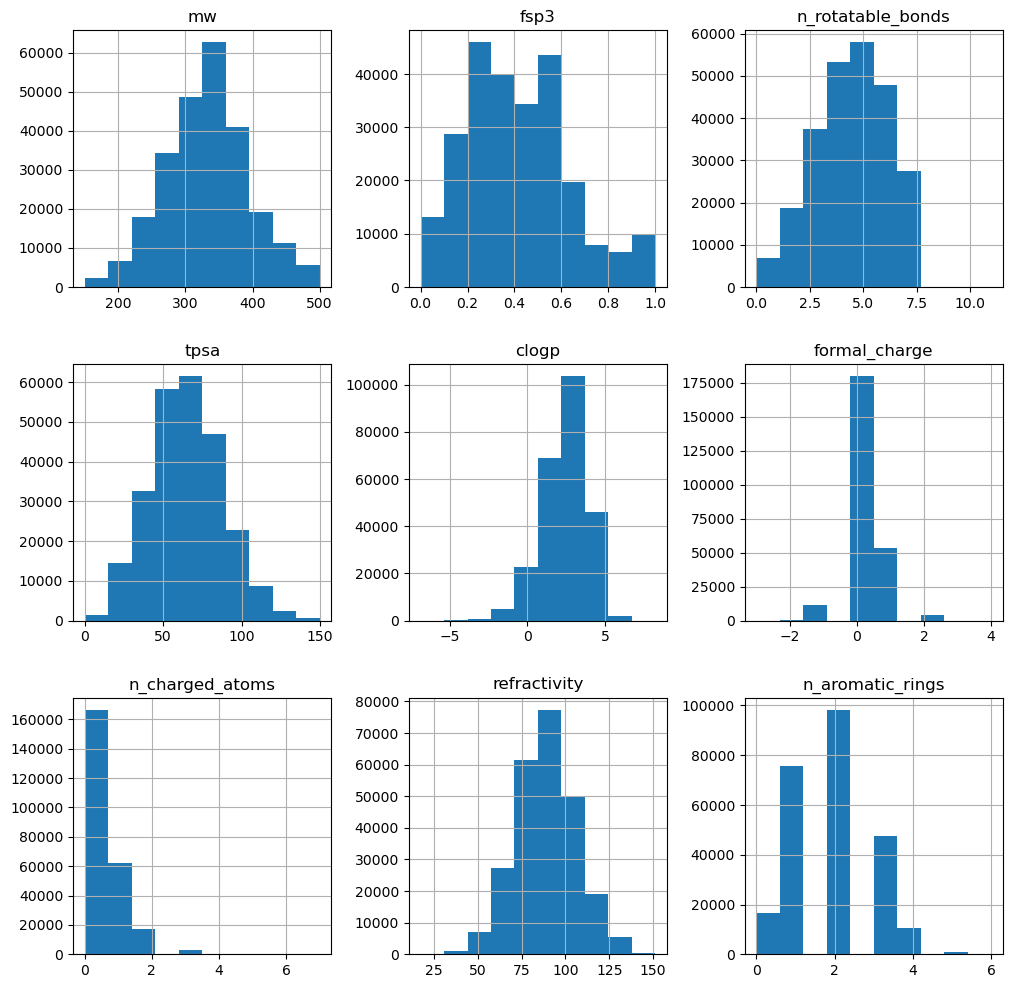

In [37]:
results.hist(figsize=(12, 12))

In [38]:
zinc250k = pd.concat([df_curated, results], axis=1)

In [39]:
zinc250k.to_parquet(
    "gs://polaris-public/Data/zinc250k/molecular_properties_curated_v1.parquet",
    index=False,
)